### Exploratory Data Analysis for BerkeleyNest Project
Notebook provides insights into Berkeley apartment market

### EDA Includes:
1. Data Cleaning and Preprocessing (referenced)
2. Examine price distributions, average rent by apartment type and neighborhood, demand indexes, etc.

Objective: Find patterns and trends to help renters make informed decisions

In [ ]:
"""
Data Cleaning and Preprocessing (reference)
Steps include:
    - Remove unnecessary columns
    - Normalize data formats (standardize rent and beds)
    - Handle missing values (fill rent values with mean of neighborhood)
    - Feature engineering (added 'distance_to_ucb_km')

Data cleaning steps are applied dynamically within BerkeleyNest app for data accuracy.
"""

"""
# Drop specified columns
columns_to_drop = [
    'primary_photo', 'alt_photos', 'property_url', 'list_date', 'last_sold_date', 'mls', 'mls_id', 
    'status', 'price_per_sqft', 'style', 'sold_price', 'unit', 'street', 'hoa_fee', 'sqft', 'year_built'
]

df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

# Normalize data formats
def preprocess_value(value):
    ## Strip the string and handle None values.
    return str(value).strip() if pd.notnull(value) and value.strip() != '' else None


def preprocess_beds(beds):
    ## Ensure the function always returns a list, correctly handling 'Studio - X' ranges.
    if beds is None or beds.strip() == '':
        return [None]
    beds_range = beds.replace('Studio', '0').split('-')
    if len(beds_range) == 2:
        beds_start, beds_end = map(int, beds_range)
        return list(range(beds_start, beds_end + 1))
    elif 'Studio' in beds:
        return [0]
    return [int(beds)]

# Make each listing individual
def expand_rows(row):
    ## Expand rows based on beds, rent, and baths ranges, correctly handling 'Studio - X'.
    expanded_rows = []
    beds_list = preprocess_beds(preprocess_value(row['beds']))
    rent = preprocess_value(row['rent'])
    baths = preprocess_value(row['baths'])

    rent_values = [float(x.replace('$', '').replace('/mo', '').replace(',', '')) for x in rent.split('-')] if rent and 'Contact' not in rent else [None]
    baths_values = [float(x) for x in baths.split('-')] if baths and '-' in baths else [float(baths)] if baths else [None]

    for bed in beds_list:
        new_row = row.copy()
        new_row['beds'] = 'Studio' if bed == 0 else str(bed)

        if rent_values[0] is not None:
            rent_for_bed = rent_values[0] if len(rent_values) == 1 else rent_values[0] + (rent_values[1] - rent_values[0]) * (beds_list.index(bed) / max(len(beds_list) - 1, 1))
            new_row['rent'] = f"${rent_for_bed:.2f}/mo"
        else:
            new_row['rent'] = "Contact For Price"

        if baths_values[0] is not None:
            baths_for_bed = baths_values[0] if len(baths_values) == 1 else baths_values[0] + (baths_values[1] - baths_values[0]) * (beds_list.index(bed) / max(len(beds_list) - 1, 1))
            new_row['baths'] = f"{baths_for_bed:.1f}"
        else:
            new_row['baths'] = ""

        expanded_rows.append(new_row)

    return expanded_rows

# Function to convert rent to a float value, returns None for 'Contact For Price'
def rent_to_float(rent):
    if 'Contact' in rent:
        return None
    else:
        return float(rent.replace('$', '').replace('/mo', '').replace(',', ''))

# Apply the function to the 'rent' column
df['rent'] = df['rent'].apply(rent_to_float)

# Calculate the average rent for each bedroom count, excluding 'Contact For Price'
average_rents = df.groupby('beds')['rent'].mean().to_dict()

# Function to replace 'Contact For Price' with the average rent
def replace_contact_for_price(row):
    if pd.isnull(row['rent']):
        return average_rents.get(row['beds'], None)
    return row['rent']

# Apply the function to each row
df['rent'] = df.apply(replace_contact_for_price, axis=1)

# Replace NaN values in 'rent' with the column average (for any missing values after replacement)
df['rent'].fillna(df['rent'].mean(), inplace=True)

# Convert 'rent' back to the original format
df['rent'] = df['rent'].apply(lambda x: f"${x:.2f}/mo")


# Ensure zip_code column is of type string
df['zip_code'] = df['zip_code'].astype(str)

# Mapping of zip codes to neighborhoods
zip_to_neighborhood = {
    "94702": "West Berkeley",
    "94703": "Central Berkeley",
    "94704": "Southside",
    "94705": "Claremont Elmwood",
    "94706": "Albany",
    "94707": "Thousand Oaks",
    "94708": "Berkeley Hills",
    "94709": "North Berkeley",
    "94710": "West Berkeley",
    "94720": "University of California, Berkeley"
}

# Replace zip_code with neighborhood
df['neighborhood'] = df['zip_code'].map(zip_to_neighborhood)

# Drop the original zip_code column
df.drop('zip_code', axis=1, inplace=True)


# Assuming 'your_data.csv' is your dataset file
df = pd.read_csv('your_data.csv')

# Convert "Studio" in 'beds' column to "0"
df['beds'] = df['beds'].replace('Studio', 0).astype(float)

# Optional: Drop 'city' and 'neighborhood' if you decide to do so
# Uncomment the next line if you decide to drop these columns
# df.drop(['city', 'neighborhood'], axis=1, inplace=True)

# Convert "Studio" in 'beds' column to "0"
df['beds'] = df['beds'].replace('Studio', 0).astype(float)

# Drop 'city' and 'neighborhood' if you decide to do so
df.drop(['city', 'neighborhood'], axis=1, inplace=True)

# Function to calculate distance using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r

# UC Berkeley coordinates
ucb_lat, ucb_lon = 37.8702, -122.2595

# Calculate distance to UC Berkeley for each row and add it to the dataframe
df['distance_to_ucb_km'] = df.apply(lambda row: haversine(ucb_lon, ucb_lat, row['longitude'], row['latitude']), axis=1)

# Save the updated dataframe to a new CSV file
df.to_csv('clean_data_with_distance.csv', index=False)

print("Updated dataframe saved to 'clean_data_with_distance.csv'.")
"""


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned dataset
df = pd.read_csv('cleaned_properties_data_with_neighborhood.csv')

# High Level Data Summary
df.describe()

,longitude,days_on_mls,baths,latitude
count,230.000000,240.000000,213.000000,230.000000
mean,-122.269529,105.000000,1.292488,37.865582
std,0.011899,108.620063,0.577192,0.009214
min,-122.301010,0.000000,1.000000,37.796411
25%,-122.276500,9.750000,1.000000,37.862174
50%,-122.269182,76.500000,1.000000,37.866014
75%,-122.261986,159.000000,1.500000,37.870897
max,-122.237845,365.000000,5.000000,37.891018


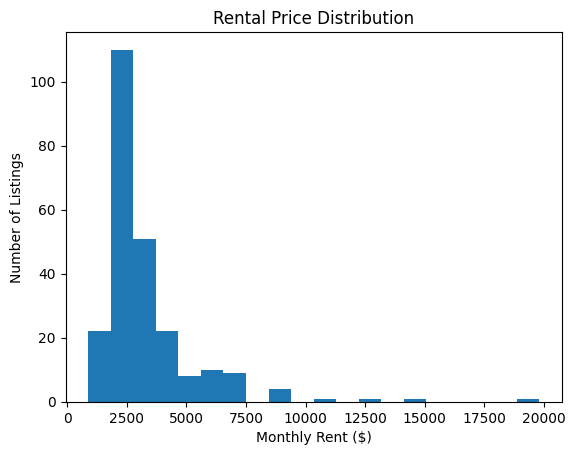

In [44]:
# Preprocess 'rent' to remove non-numeric values
df['rent'] = df['rent'].str.replace('$', '').str.replace('/mo', '').str.replace(',', '')
df['rent'] = pd.to_numeric(df['rent'], errors='coerce')

# Fill NaN rent values with the mean
df['rent'].fillna(df['rent'].mean(), inplace=True)

# Rental price distribution
plt.hist(df['rent'], bins=20)
plt.title('Rental Price Distribution')
plt.xlabel('Monthly Rent ($)')
plt.ylabel('Number of Listings')
plt.show()

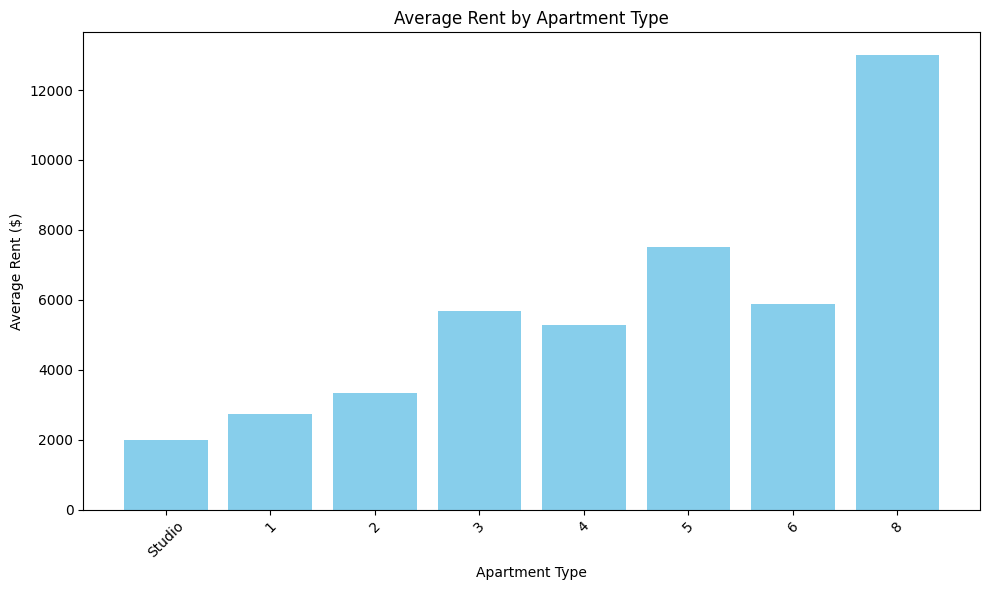

In [45]:
# Average Rent by Apartment Type
avg_rent_by_type = df.groupby('beds')['rent'].mean().reset_index()
avg_rent_by_type['beds'] = avg_rent_by_type['beds'].astype(str)  # Convert beds to string for better representation

# Sort the 'beds' column based on a custom order, ensuring 'Studio' is first
custom_order = {'Studio': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
avg_rent_by_type['order'] = avg_rent_by_type['beds'].map(custom_order)
avg_rent_by_type = avg_rent_by_type.sort_values('order')

# Creating a bar chart for the average rent by apartment type
plt.figure(figsize=(10, 6))
plt.bar(avg_rent_by_type['beds'], avg_rent_by_type['rent'], color='skyblue')
plt.title('Average Rent by Apartment Type')
plt.xlabel('Apartment Type')
plt.ylabel('Average Rent ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

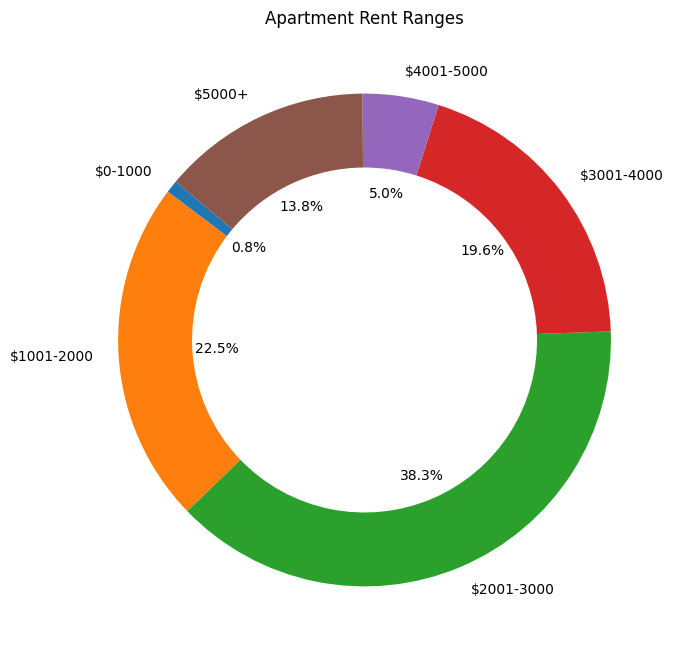

In [46]:
# Apartment Rent Ranges Donut Chart
rent_bins = [0, 1000, 2000, 3000, 4000, 5000, np.inf]
rent_labels = ['$0-1000', '$1001-2000', '$2001-3000', '$3001-4000', '$4001-5000', '$5000+']
df['rent_range'] = pd.cut(df['rent'], bins=rent_bins, labels=rent_labels)
rent_range_counts = df['rent_range'].value_counts().sort_index()
plt.figure(figsize=(8, 8))
plt.pie(rent_range_counts, labels=rent_range_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Apartment Rent Ranges')
plt.show()

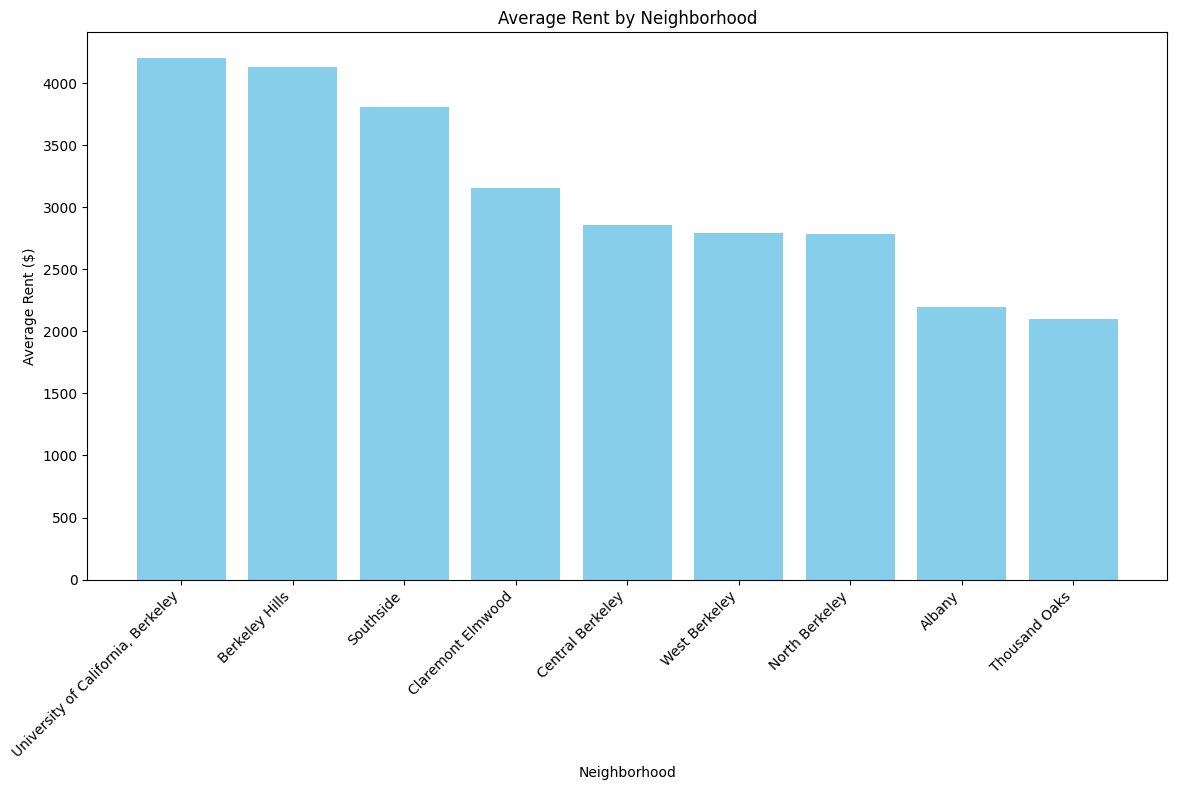

In [47]:
# Average Rent by Neighborhood
avg_rent_by_neighborhood = df.groupby('neighborhood')['rent'].mean().reset_index()

plt.figure(figsize=(12, 8))
avg_rent_sorted = avg_rent_by_neighborhood.sort_values('rent', ascending=False)
plt.bar(avg_rent_sorted['neighborhood'], avg_rent_sorted['rent'], color='skyblue')
plt.title('Average Rent by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Rent ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

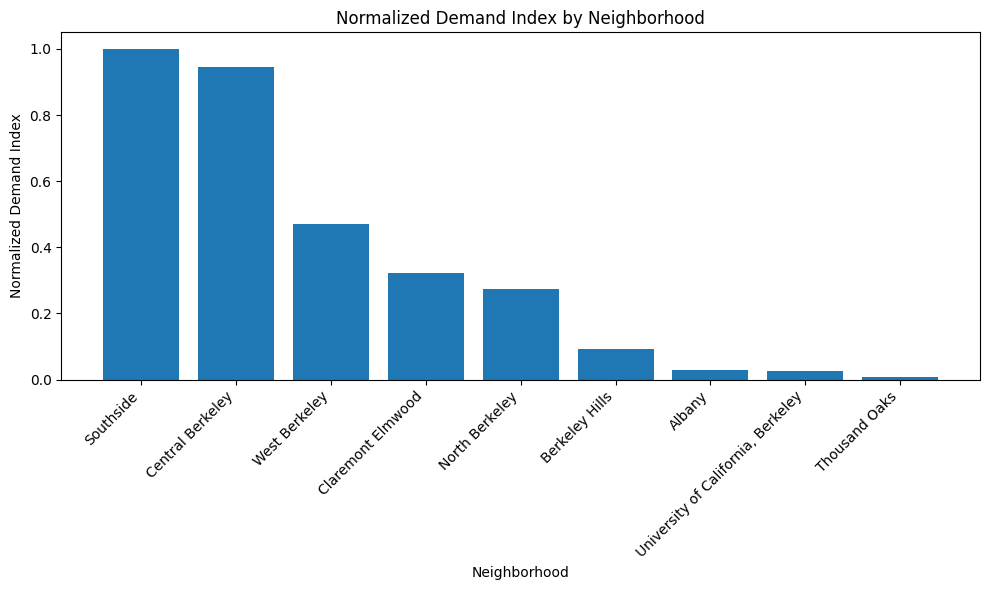

In [48]:
# Assuming 'df' has columns 'neighborhood' and 'days_on_mls'
# Calculate Demand Index
df['days_on_mls'] = pd.to_numeric(df['days_on_mls'], errors='coerce').fillna(0)

# Step 1: Aggregate total DOM and count listings per neighborhood
demand_data = df.groupby('neighborhood')['days_on_mls'].agg(['sum', 'count']).reset_index()
demand_data.rename(columns={'sum': 'total_DOM', 'count': 'listings'}, inplace=True)

# Step 2: Calculate initial demand index
demand_data['average_DOM'] = demand_data['total_DOM'] / demand_data['listings']
max_listings = demand_data['listings'].max()
demand_data['demand_index'] = demand_data['listings'].apply(lambda x: x / max_listings) / demand_data['average_DOM']

# Step 3: Normalize the demand index to a 0-1 scale
max_demand_index = demand_data['demand_index'].max()
demand_data['normalized_demand_index'] = demand_data['demand_index'] / max_demand_index

# Visualize Demand Index
plt.figure(figsize=(10, 6))
demand_data.sort_values('normalized_demand_index', ascending=False, inplace=True)
plt.bar(demand_data['neighborhood'], demand_data['normalized_demand_index'])
plt.xticks(rotation=45, ha='right')
plt.title('Normalized Demand Index by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Normalized Demand Index')
plt.tight_layout()
plt.show()

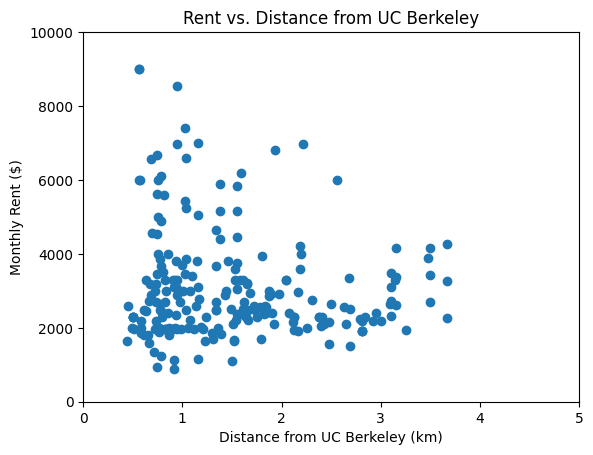

In [49]:
# Ensure 'rent' is treated as a string before attempting to replace characters
df['rent'] = df['rent'].astype(str)

# Now apply the replacements and convert to float
df['rent'] = df['rent'].str.replace('$', '').str.replace('/mo', '').str.replace(',', '').astype(float)

# Proceed with the distance calculation and plotting
# Ensure the 'longitude' and 'latitude' are numeric for the haversine function
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')

# Calculate distance to UC Berkeley for each row and add it to the dataframe
df['distance_to_ucb_km'] = df.apply(lambda row: haversine(ucb_lon, ucb_lat, row['longitude'], row['latitude']), axis=1)

# Filter the DataFrame for distances within 5km and rents under $10,000
filtered_df = df[(df['distance_to_ucb_km'] <= 5) & (df['rent'] < 10000)]

# Scatter Plot for Rent vs. Distance to UC Berkeley with filters applied
plt.scatter(filtered_df['distance_to_ucb_km'], filtered_df['rent'])
plt.title('Rent vs. Distance from UC Berkeley')
plt.xlabel('Distance from UC Berkeley (km)')
plt.ylabel('Monthly Rent ($)')
plt.xlim(0, 5)  # Limiting x-axis to 5km
plt.ylim(0, 10000)  # Limiting y-axis to $10,000 rent
plt.show()

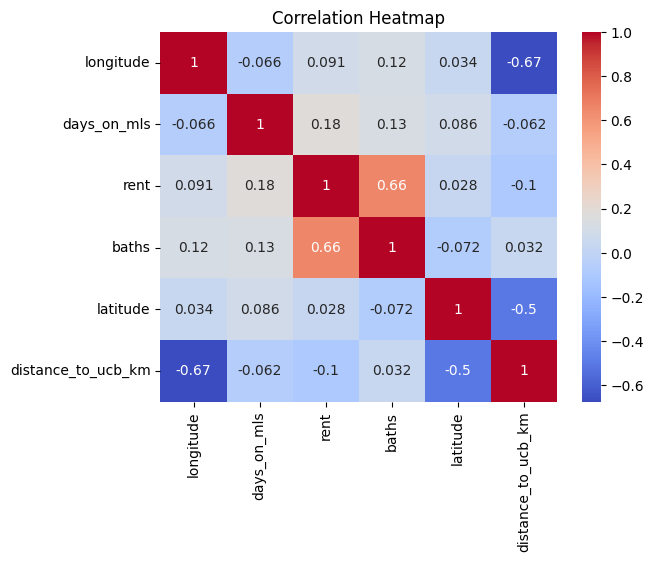

In [50]:
# Convert 'beds' to numeric, handling non-numeric gracefully
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
# Filter out non-numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Correlation Heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Conclusion

- **Price Range:** Most apartments fall between $1000-4000 (broad range of affordability)
  - Implemented price range search filter based on these ranges
- **Apartment Type vs. Rent:** Linear relationship between beds/baths and average rent (some exceptions)
  - Implemented search filter based on apartment type 
- **Neighborhood Impact:** Distance to UC Berkeley is not directly correlated with higher rent, suggesting other factors like public transportation play a role
  - Implemented Interactive Map for Average Rent for users to explore rent trends across Berkeley
- **Demand Index:** Neighborhoods closer to campus and with a high concentration of apartments show a higher demand index.
  - Created Demand Index Map for users to easily compare demand in neighborhoods
- **Distance to UC Berkeley:** Despite my assumptions, this was not directly correlated with higher rent. Tailored the web app to include other metrics that influence rent more.